In [23]:
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import open3d as o3d
import os
from torch.utils.data import Dataset, DataLoader, Subset
from dataclasses import dataclass
import sys
from pathlib import Path
from pytorch3d.loss import chamfer_distance
from tqdm import tqdm

sys.path.append(str(Path.cwd().parent))

from Helpers.data import PointCloudDataset
import Helpers.PointCloudOpen3d as pc

if torch.cuda.is_available():
    device = "cuda"

elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f'Using: {device}')

Using: cuda


In [318]:
names = {}
for root, _, files in os.walk("../Data/ModelNet40"):
    for file in files:
        if file.endswith('.off'):
            full_path = os.path.join(root, file)
            if f'train' in full_path:
                name = file.split('_')[0]
                if name in names:
                    names[name] = names[name] + 1
                else:
                    names[name] = 0

big_object_classes = []
for name in names.keys():
    if names[name] < 190: 
        print(f'{name} : {names[name]}')
        big_object_classes.append(name)
print(len(names))

bathtub : 105
bench : 172
bowl : 63
cone : 166
cup : 78
curtain : 137
door : 108
flower : 148
glass : 170
guitar : 154
keyboard : 144
lamp : 123
laptop : 148
person : 87
radio : 103
range : 114
sink : 127
stairs : 123
stool : 89
tent : 162
wardrobe : 86
xbox : 102
40


In [ ]:
point_size = 3072
train_dataset = PointCloudDataset("../Data/ModelNet40", point_size, 'train', object_classes = None )
test_dataset = PointCloudDataset("../Data/ModelNet40", point_size, 'test', object_classes = None)


c:\Users\zfogg\OneDrive\git\Neural-Sign-Distance-Learning\Helpers\data.py:69: RuntimeWarning: invalid value encountered in divide
  scaled_points = ((points - min_coords) / range_coords) #scales points on range [0, 1]
c:\Users\zfogg\OneDrive\git\Neural-Sign-Distance-Learning\Helpers\data.py:70: RuntimeWarning: invalid value encountered in cast
  scaled_points = (scaled_points * (2**num_bits - 1)).astype(int) # scales points to [0, 2^num_bits]


2468
9843


In [18]:
test_size = len(test_dataset)
split_idx = test_size // 2
indices = list(range(test_size))
val_dataset = Subset(test_dataset, indices[:split_idx])
test_dataset = Subset(test_dataset, indices[split_idx:])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 128, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = True)

In [48]:

class ConvDecoder(nn.Module):
    
    def __init__(self, point_size, latent_dim):
        super().__init__()
        
        self.point_size = point_size

        self.l1 = nn.Linear(latent_dim, 1024)
        self.l2 = nn.Linear(1024, 2048)
        self.l3 = nn.Linear(2048, 3072)
        self.l4 = nn.Linear(3072, point_size * 3)

    def forward(self, x):
        x = F.gelu(self.l1(x))
        x = F.gelu(self.l2(x))
        x = F.gelu(self.l3(x))
        x = self.l4(x)
        x = x.view(-1, self.point_size, 3)
        return x    
    
class ConvEncoder_2800T(nn.Module):
    
    def __init__(self, point_size, latent_size):
        super().__init__()

        self.point_size = point_size 

        # Points talk to each other wo/ downsampling 
        self.conv1 = nn.Conv1d(3, 32, kernel_size = 9, stride= 1, padding= 4)
        self.conv2 = nn.Conv1d(32, 32, kernel_size = 9, stride = 1, padding = 4)

        # Downsampling 
        self.conv3 = nn.Conv1d(32, 32, kernel_size = 8, stride = 2, padding = 3)
        self.conv4 = nn.Conv1d(32, 32, kernel_size = 8, stride = 2, padding = 3)
        self.conv5 = nn.Conv1d(32, 32, kernel_size = 8, stride = 2, padding = 3)
        self.conv6 = nn.Conv1d(32, 32, kernel_size = 8, stride = 2, padding = 3)
        self.conv7 = nn.Conv1d(32, 32, kernel_size = 8, stride = 2, padding = 3)

        # Linear 
        self.lin1 = nn.Linear(point_size , latent_size)

    def forward(self, x):
        
        x = F.gelu(self.conv1(x))
        x = F.gelu(self.conv2(x))
        x = F.gelu(self.conv3(x))
        x = F.gelu(self.conv4(x))
        x = F.gelu(self.conv5(x))
        x = F.gelu(self.conv6(x))
        x = F.gelu(self.conv7(x))

        x = x.view(-1, self.point_size)

        x = self.lin1(x)

        return x


class ConvAE_2800T(nn.Module):
    
    def __init__(self, point_size, latent_size):
        super().__init__()

        self.encoder = ConvEncoder_2800T(point_size, latent_size)
        self.decoder = ConvDecoder(point_size, latent_size)

    def forward(self, x):
        latent_rep = self.encoder(x)
        reconstructed_cloud = self.decoder(latent_rep)
        return reconstructed_cloud

In [34]:

model = ConvAE_2800T(3072,512)
total = 0
for name,param in model.named_parameters():
    if "encoder" in name: 
        total += param.numel()

print(total)

3193392


In [49]:


model = ConvAE_2800T(3072, 512).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

min_val_loss = np.inf

epochs = 1

for epoch in range(epochs):

    # Train one epoch
    train_loss = 0 

    for data in train_loader:
        
        x = data['points'].to(device)

        reconstructed_x = model(x.permute(0,2,1)) # Model expects point clouds to be (3, num_points)
        optimizer.zero_grad()

        print(reconstructed_x.shape)
        print(x.shape)
        loss, _ = chamfer_distance(x, reconstructed_x)

        loss.backward()

        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    # Calculate validation loss

    val_loss = 0 

    for data in val_loader:

        x = data['points'].to(device)

        with torch.no_grad():
            reconstructed_x = model(x.permute(0,2,1))
            loss, _ = chamfer_distance(x, reconstructed_x)
            val_loss+= loss.item()

    val_loss /= len(val_loader)

    print(f'\nEpoch {epoch+1} \t Train Loss: {train_loss:.5f} \t Val Loss: {val_loss:.5f}')

    # Save best model
    if val_loss < min_val_loss:
        print(f'Val Loss Decreased({min_val_loss:.6f} ---> {val_loss:.6f}) \t Saving The Model')
        min_val_loss = val_loss

        torch.save(model.state_dict(), './trained_models/ConvEnc_LinDec/ConvAutoEncoder_ModelNet40_test')
    

torch.Size([128, 3072, 3])
torch.Size([128, 3072, 3])
torch.Size([128, 3072, 3])
torch.Size([128, 3072, 3])
torch.Size([128, 3072, 3])
torch.Size([128, 3072, 3])
torch.Size([128, 3072, 3])
torch.Size([128, 3072, 3])
torch.Size([128, 3072, 3])
torch.Size([128, 3072, 3])
torch.Size([128, 3072, 3])
torch.Size([128, 3072, 3])
torch.Size([128, 3072, 3])
torch.Size([128, 3072, 3])
torch.Size([128, 3072, 3])
torch.Size([128, 3072, 3])
torch.Size([128, 3072, 3])
torch.Size([128, 3072, 3])
torch.Size([128, 3072, 3])
torch.Size([128, 3072, 3])
torch.Size([128, 3072, 3])
torch.Size([128, 3072, 3])
torch.Size([128, 3072, 3])
torch.Size([128, 3072, 3])
torch.Size([128, 3072, 3])
torch.Size([128, 3072, 3])
torch.Size([128, 3072, 3])
torch.Size([128, 3072, 3])
torch.Size([128, 3072, 3])
torch.Size([128, 3072, 3])
torch.Size([128, 3072, 3])
torch.Size([128, 3072, 3])
torch.Size([128, 3072, 3])
torch.Size([128, 3072, 3])
torch.Size([128, 3072, 3])
torch.Size([128, 3072, 3])
torch.Size([128, 3072, 3])
t

KeyboardInterrupt: 

In [ ]:
best_model = ConvAE_2700T(2048, 512)
best_model.load_state_dict(torch.load('./trained_models/ConvEnc_LinDec/ConvAutoEncoder_ModelNet40_2700T', weights_only=True))
best_model.to(device)
best_model.eval()
pc.visualize_random_reconstruction(best_model, val_loader, device)

In [207]:
pc.visualize_random_reconstruction(best_model, val_loader, device)

In [354]:
pc.visualize_random_reconstruction(model, val_loader, device)

In [25]:
def train_model(key, model, num_epochs, train_loader, val_loader):

    optimizer = optim.AdamW(model.parameters(), lr=0.0001)

    min_val_loss = np.inf

    train_losses = []
    val_losses = []

    for epoch in tqdm(range(num_epochs)):

        # Train one epoch
        train_loss = 0 

        for data in train_loader:
            
            x = data['points'].to(device)

            reconstructed_x = model(x.permute(0,2,1)) # Model expects point clouds to be (3, num_points)
            optimizer.zero_grad()
            loss, _ = chamfer_distance(x, reconstructed_x)

            loss.backward()

            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Calculate validation loss

        val_loss = 0 

        for data in val_loader:

            x = data['points'].to(device)

            with torch.no_grad():
                reconstructed_x = model(x.permute(0,2,1))
                loss, _ = chamfer_distance(x, reconstructed_x)
                val_loss+= loss.item()

        val_loss /= len(val_loader)

        # print(f'\nEpoch {epoch+1} \t Train Loss: {train_loss:.5f} \t Val Loss: {val_loss:.5f}')

        # Save best model
        if val_loss < min_val_loss:
            # print(f'Val Loss Decreased({min_val_loss:.6f} ---> {val_loss:.6f}) \t Saving The Model')
            min_val_loss = val_loss

            torch.save(model.state_dict(), f'./trained_models/ConvEnc_LinDec/3072_512/ConvAE_{key}')

        train_losses.append(train_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

import autoencoders as ae

### Experiment 
num_epochs = 5
point_size = 3072 
latent_size = 512

models = {
    '5800T' : ConvAE_5800T,
    '5400T' : ae.ConvAE_5400T,
    '4700T' : ae.ConvAE_4700T,
    '3200T' : ae.ConvAE_3200T,
    '2800T' : ae.ConvAE_2800T,
    '570T' : ae.ConvAE_570T
}
training_results = {}


for key in models.keys(): 

    print(f'Training {key} model')
    
    model = models[key](point_size, latent_size).to(device)

    train_losses, val_losses = train_model(key, model, num_epochs, train_loader, val_loader)
    
    training_results[key] = {'train_losses' : train_losses, 'val_losses' : val_losses}
    


Training 5800T model


100%|██████████| 5/5 [00:45<00:00,  9.09s/it]


Training 5400T model


100%|██████████| 5/5 [00:15<00:00,  3.04s/it]


Training 4700T model


100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


Training 3200T model


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


Training 2800T model


  0%|          | 0/5 [00:00<?, ?it/s]


ValueError: y does not have the correct shape.

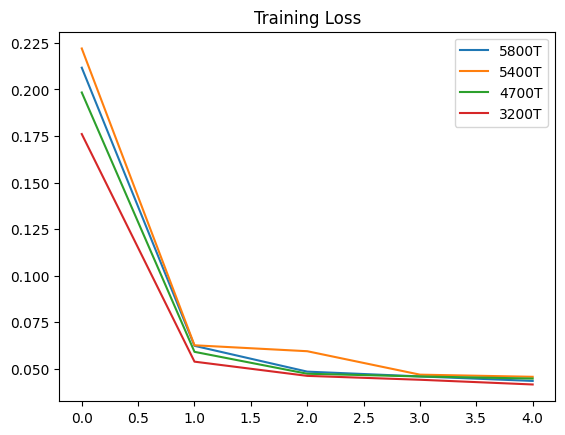

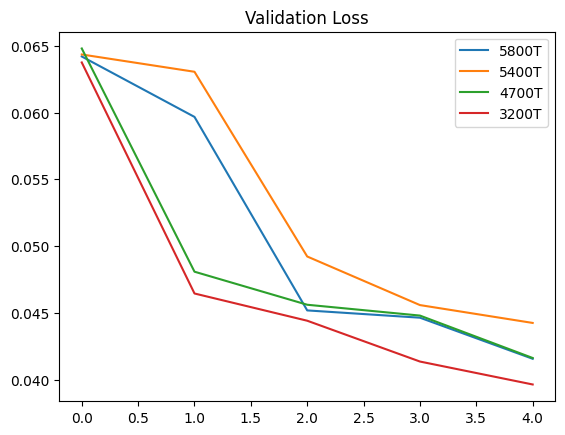

In [51]:
epochs = list(range(num_epochs))

for key in training_results.keys():
    plt.plot(epochs, training_results[key]['train_losses'], label = key)

plt.title('Training Loss')
plt.legend()
plt.show()


for key in training_results.keys():
    plt.plot(epochs, training_results[key]['val_losses'], label = key)

plt.title('Validation Loss')
plt.legend()
plt.show()